In [1]:
%matplotlib inline

from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiime2 import Artifact, Metadata
from qiime2.plugins import diversity, empress
import scipy.stats as ss
import seaborn as sns

# Figure 1A - Full EMP Visualization

This will walkthrough the procedure of generating the EMPire plot of the full EMP dataset.

In [2]:
# Clear the output directory and create a fresh one
!rm -rf fig1/output
!mkdir -p fig1/output

## Downloading Required Data

First, we will download the EMP data via FTP. Note that we do not include these files in the repository because they are fairly large.

In [3]:
# EMP table
!wget -O fig1/input/EMP_tbl.biom ftp://ftp.microbio.me/emp/release1/otu_tables/deblur/emp_deblur_90bp.release1.biom

--2021-02-04 13:39:26--  ftp://ftp.microbio.me/emp/release1/otu_tables/deblur/emp_deblur_90bp.release1.biom
           => ‘fig1/input/EMP_tbl.biom’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/otu_tables/deblur ... done.
==> SIZE emp_deblur_90bp.release1.biom ... 269396269
==> PASV ... done.    ==> RETR emp_deblur_90bp.release1.biom ... done.
Length: 269396269 (257M) (unauthoritative)

emp_deblur_90bp.rel 100%[===================>] 256.92M  12.8MB/s    in 38s     

2021-02-04 13:40:05 (6.80 MB/s) - ‘fig1/input/EMP_tbl.biom’ saved [269396269]



In [4]:
# EMP tree
!wget -O fig1/input/EMP_tree.tre ftp://ftp.microbio.me/emp/release1/otu_info/deblur/emp90.5000_1000_rxbl_placement_pruned75.tog.tre

--2021-02-04 13:40:05--  ftp://ftp.microbio.me/emp/release1/otu_info/deblur/emp90.5000_1000_rxbl_placement_pruned75.tog.tre
           => ‘fig1/input/EMP_tree.tre’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/otu_info/deblur ... done.
==> SIZE emp90.5000_1000_rxbl_placement_pruned75.tog.tre ... 41472507
==> PASV ... done.    ==> RETR emp90.5000_1000_rxbl_placement_pruned75.tog.tre ... done.
Length: 41472507 (40M) (unauthoritative)

emp90.5000_1000_rxb 100%[===================>]  39.55M  7.95MB/s    in 9.5s    

2021-02-04 13:40:16 (4.17 MB/s) - ‘fig1/input/EMP_tree.tre’ saved [41472507]



In [5]:
# EMP mapping file
!wget -O fig1/input/EMP_metadata.tsv ftp://ftp.microbio.me/emp/release1/mapping_files/emp_qiime_mapping_release1.tsv

--2021-02-04 13:40:16--  ftp://ftp.microbio.me/emp/release1/mapping_files/emp_qiime_mapping_release1.tsv
           => ‘fig1/input/EMP_metadata.tsv’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/mapping_files ... done.
==> SIZE emp_qiime_mapping_release1.tsv ... 21876184
==> PASV ... done.    ==> RETR emp_qiime_mapping_release1.tsv ... done.
Length: 21876184 (21M) (unauthoritative)

emp_qiime_mapping_r 100%[===================>]  20.86M  5.28MB/s    in 6.2s    

2021-02-04 13:40:23 (3.36 MB/s) - ‘fig1/input/EMP_metadata.tsv’ saved [21876184]



Next, we'll import the table and tree files as `qza` Artifacts so that they can be used with EMPress.

In [6]:
!qiime tools import \
    --type FeatureTable[Frequency] \
    --input-path fig1/input/EMP_tbl.biom \
    --output-path fig1/output/EMP_tbl.qza

Imported fig1/input/EMP_tbl.biom as BIOMV210DirFmt to fig1/output/EMP_tbl.qza


In [7]:
!qiime tools import \
    --type Phylogeny[Rooted] \
    --input-path fig1/input/EMP_tree.tre \
    --output-path fig1/output/EMP_tree.qza

Imported fig1/input/EMP_tree.tre as NewickDirectoryFormat to fig1/output/EMP_tree.qza


## Simplify Phylum-Level Assignments

For ease of visualization, we will use each microbial feature's phylum level assignment for subsequent taxonomic representation. These assignments are stored within the original `biom` table. We will first extract this file and replace missing values with "Unspecified."

In [8]:
tbl_biom = load_table("fig1/input/EMP_tbl.biom")
taxonomy_df = tbl_biom.metadata_to_dataframe(axis="observation")
#taxonomy_df.columns = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
taxonomy_df.index.name = "featureid"
taxonomy_df = taxonomy_df.fillna("Unspecified")
print(taxonomy_df.shape)
taxonomy_df.head()

(317314, 7)


,taxonomy_0,taxonomy_1,taxonomy_2,taxonomy_3,taxonomy_4,taxonomy_5,taxonomy_6
featureid,,,,,,,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Alteromonadaceae,g__Marinimicrobium,s__
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,k__Bacteria,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,k__Bacteria,p__Proteobacteria,c__Deltaproteobacteria,Unspecified,Unspecified,Unspecified,Unspecified
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,k__Bacteria,p__Planctomycetes,c__028H05-P-BN-P5,o__,f__,g__,s__
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,k__Bacteria,p__Planctomycetes,c__Planctomycetia,o__Pirellulales,f__Pirellulaceae,g__,s__


We will save this taxonomy file as its own feature metadata file independent of the feature table.

In [9]:
Metadata(taxonomy_df).save("fig1/output/EMP_taxonomy.tsv")

We want to keep only the top 5 most abundant phlyum (taxonomy_1) assignments.

In [10]:
taxonomy_df["taxonomy_1"].value_counts().head(6) # top 5 + Unspecified

p__Proteobacteria    83037
Unspecified          44143
p__Bacteroidetes     26406
p__Firmicutes        23834
p__Planctomycetes    22177
p__Chloroflexi       16042
Name: taxonomy_1, dtype: int64

In [11]:
top_5_phyla_counts = taxonomy_df["taxonomy_1"].value_counts()[:6]
top_5_phyla = top_5_phyla_counts.index.tolist()
bot_phyla = taxonomy_df["taxonomy_1"].value_counts()[6:].index.tolist()
top_5_phyla.remove("Unspecified")
bot_phyla.append("Unspecified")
phylum_assignments = ["Other/Unspecified" if not x in top_5_phyla else x for x in taxonomy_df["taxonomy_1"]]
top_5_phyla_df = pd.DataFrame.from_dict(dict(zip(taxonomy_df.index.tolist(), phylum_assignments)), orient="index")
top_5_phyla_df.columns = ["phylum_assignment"]
top_5_phyla_df.index.name = "featureid"
top_5_phyla_df.head()

,phylum_assignment
featureid,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,p__Proteobacteria
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,Other/Unspecified
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,p__Proteobacteria
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,p__Planctomycetes
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,p__Planctomycetes


We will save this file as a `tsv` file that QIIME2 can read.

In [12]:
Metadata(top_5_phyla_df).save("fig1/output/EMP_top_5_phyla.tsv")

## Filtering Feature Table

The original EMP data includes samples from both sterile water blanks and mock communities. We will remove samples of both these types.

In [13]:
!qiime feature-table filter-samples \
    --i-table fig1/output/EMP_tbl.qza \
    --m-metadata-file fig1/input/EMP_metadata.tsv \
    --p-where "[empo_2] NOT IN ('Positive', 'Negative')" \
    --o-filtered-table fig1/output/EMP_tbl_filt.qza

Saved FeatureTable[Frequency] to: fig1/output/EMP_tbl_filt.qza


Additionally, we will filter the feature table by the phylogeny to make sure all features present in the feature table are present in the phylogeny as well.

In [14]:
!qiime phylogeny filter-table \
    --i-table fig1/output/EMP_tbl_filt.qza \
    --i-tree fig1/output/EMP_tree.qza \
    --o-filtered-table fig1/output/EMP_tbl_filt.qza

Saved FeatureTable[Frequency] to: fig1/output/EMP_tbl_filt.qza


## Filtering Metadata

The EMP dataset is fairly large so the metadata takes up a good amount of storage. We will pare down the provided metadata file a bit so that the final Visualization is small enough to upload to GitHub.

In [15]:
metadata = pd.read_csv("fig1/input/EMP_metadata.tsv", sep="\t", index_col=0)
metadata.head()

,BarcodeSequence,LinkerPrimerSequence,Description,host_subject_id,study_id,title,principal_investigator,doi,ebi_accession,target_gene,...,adiv_shannon,adiv_faith_pd,temperature_deg_c,ph,salinity_psu,oxygen_mg_per_l,phosphate_umol_per_l,ammonium_umol_per_l,nitrate_umol_per_l,sulfate_umol_per_l
#SampleID,,,,,,,,,,,,,,,,,,,,,
550.L1S1.s.1.sequence,AACGCACGCTAG,GTGCCAGCMGCCGCGGTAA,sample_1 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,4.244831,13.631804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S10.s.1.sequence,ACAGACCACTCA,GTGCCAGCMGCCGCGGTAA,sample_2 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.027416,9.425835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S100.s.1.sequence,ATGCACTGGCGA,GTGCCAGCMGCCGCGGTAA,sample_3 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.196420,10.491161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S101.s.1.sequence,ATTATCGTGCAC,GTGCCAGCMGCCGCGGTAA,sample_4 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.714719,11.384689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S102.s.1.sequence,CACGACAGGCTA,GTGCCAGCMGCCGCGGTAA,sample_5 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.969038,15.162691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are going to keep only a few metadata categories that we think are useful for interactive visualization.

In [16]:
cols_to_keep = [
    "empo_1", "empo_2", "empo_3", "study_id", "sample_scientific_name",
    "host_common_name", "env_material", "country"
]

In [17]:
metadata_filt = metadata[cols_to_keep]
print(metadata_filt.shape)
Metadata(metadata_filt).save("fig1/input/EMP_metadata_filt.tsv")

(27751, 8)


## Running EMPress

Finally, we will generate an EMPire plot combining an interactive tree visualization with a PCoA. The distance matrix and PCoA are very computationally intensive to calculate so we have included the pre-computed PCoA in `fig1/input`. The code used to generate the unweighted UniFrac distance matrix and PCoA are shown below (not executed).

```bash
qiime diversity beta-phylogenetic \
    --i-table fig1/ouptut/EMP_tbl_filt.qza \
    --i-phylogeny fig1/output/EMP_tree.qza \
    --p-metric unweighted_unifrac \
    --p-n-jobs 32 \
    --o-distance-matrix fig1/output/EMP_u_unifrac_dm.qza
    
qiime diversity pcoa \
    --i-distance-matrix fig1/output/EMP_u_unifrac_dm.qza \
    --p-number-of-dimensions 3 \
    --o-pcoa fig1/input/EMP_u_unifrac_pcoa.qza
```

In [18]:
!qiime empress community-plot \
    --i-tree fig1/output/EMP_tree.qza \
    --i-feature-table fig1/output/EMP_tbl_filt.qza \
    --i-pcoa fig1/input/EMP_u_unifrac_pcoa.qza \
    --m-sample-metadata-file fig1/input/EMP_metadata_filt.tsv \
    --m-feature-metadata-file fig1/output/EMP_top_5_phyla.tsv \
    --m-feature-metadata-file fig1/output/EMP_taxonomy.tsv \
    --o-visualization fig1/output/EMP_empire.qzv

Saved Visualization to: fig1/output/EMP_empire.qzv


# Figure 1B

Now we will recreate the subtree with the pH metadata. First, we will import the sample metadata to see the overall distribution of pH values.

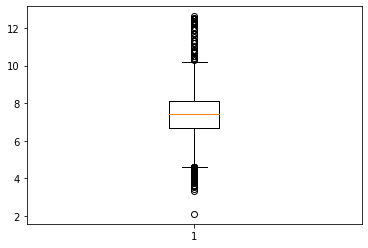

In [19]:
ph_vals = metadata["ph"].dropna()
plt.boxplot(ph_vals)
plt.show()

To remove outliers, we are going to retain only the samples in the middle 90% of the range of pH values.

In [20]:
q1, q2 = [ph_vals.quantile(x) for x in [0.05, 0.95]]
print(q1, q2)

4.7 9.0


In [21]:
!qiime feature-table filter-samples \
    --i-table fig1/output/EMP_tbl_filt.qza \
    --m-metadata-file fig1/input/EMP_metadata.tsv \
    --p-where "[ph] >= 4.7 AND [ph] <= 9" \
    --o-filtered-table fig1/output/ph_EMP_tbl_filt.qza

Saved FeatureTable[Frequency] to: fig1/output/ph_EMP_tbl_filt.qza


For each feature, we will calculate:

1. The number of samples in which it appears
2. The arithmetic mean pH value of these samples
3. The geometric mean pH value of these samples

In [22]:
ph_tbl_df = Artifact.load("fig1/output/ph_EMP_tbl_filt.qza").view(pd.DataFrame)
features = ph_tbl_df.columns.tolist()
feature_ph_dict = dict()

for feature in features:
    feature_ph_dict[feature] = dict()
    samps = ph_tbl_df.loc[:, feature]
    samps = samps[samps > 0].index.tolist()
    ph_vals = metadata.loc[samps]["ph"].tolist()
    feature_ph_dict[feature]["sample_presence"] = len(samps)
    feature_ph_dict[feature]["geometric_mean"] = ss.mstats.gmean(ph_vals)
    feature_ph_dict[feature]["arithmetic_mean"] = np.mean(ph_vals)
    
ph_mean_df = pd.DataFrame.from_dict(feature_ph_dict, orient="index")
ph_mean_df.index.name = "featureid"
ph_mean_df.head()

,sample_presence,geometric_mean,arithmetic_mean
featureid,,,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,2,8.558505,8.560000
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,2,5.494616,5.495000
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,10,7.045974,7.100000
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,17,7.830167,7.852941
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,26,7.602140,7.613846


In [23]:
# log10 samples to tighten scale for colorbar
ph_mean_df["log10_sample_presence"] = ph_mean_df["sample_presence"].apply(np.log10)

In [24]:
Metadata(ph_mean_df).save("fig1/output/ph_EMP_feature_metadata.tsv")

In [25]:
!qiime empress community-plot \
    --i-tree fig1/output/EMP_tree.qza \
    --i-feature-table fig1/output/ph_EMP_tbl_filt.qza \
    --m-sample-metadata-file fig1/input/EMP_metadata_filt.tsv \
    --m-feature-metadata-file fig1/output/EMP_top_5_phyla.tsv \
    --m-feature-metadata-file fig1/output/ph_EMP_feature_metadata.tsv \
    --m-feature-metadata-file fig1/output/EMP_taxonomy.tsv \
    --o-visualization fig1/output/ph_EMP_empress.qzv

Saved Visualization to: fig1/output/ph_EMP_empress.qzv


# Figure 1C

Finally, we will plot the distributions of pH for the top 5 most abundant phyla in the EMP features.

In [26]:
ph_taxonomy = taxonomy_df.join(ph_mean_df)
ph_taxonomy.head()

,taxonomy_0,taxonomy_1,taxonomy_2,taxonomy_3,taxonomy_4,taxonomy_5,taxonomy_6,sample_presence,geometric_mean,arithmetic_mean,log10_sample_presence
featureid,,,,,,,,,,,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Alteromonadaceae,g__Marinimicrobium,s__,2.0,8.558505,8.560000,0.301030
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,k__Bacteria,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,2.0,5.494616,5.495000,0.301030
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,k__Bacteria,p__Proteobacteria,c__Deltaproteobacteria,Unspecified,Unspecified,Unspecified,Unspecified,10.0,7.045974,7.100000,1.000000
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,k__Bacteria,p__Planctomycetes,c__028H05-P-BN-P5,o__,f__,g__,s__,17.0,7.830167,7.852941,1.230449
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,k__Bacteria,p__Planctomycetes,c__Planctomycetia,o__Pirellulales,f__Pirellulaceae,g__,s__,26.0,7.602140,7.613846,1.414973


We will first perform a similar procedure as above where we mask phyla outside the top 5 most abundant as "Other/Unspecified". Then we will assign the order of the top 5 phyla in increasing median mean pH.

In [27]:
other_phyla = [x for x in ph_taxonomy["taxonomy_1"].unique() if x not in top_5_phyla]
ph_phyla_mean_df = ph_taxonomy.copy()[["taxonomy_1", "arithmetic_mean"]]
ph_phyla_mean_df["taxonomy_1"] = ph_phyla_mean_df["taxonomy_1"].replace({x: "Other/Unspecified" for x in other_phyla})
ph_phyla_mean_df = ph_phyla_mean_df.dropna()
order = ph_phyla_mean_df.groupby("taxonomy_1").median().sort_values(by="arithmetic_mean", ascending=True).index.tolist()
order.remove("Other/Unspecified") # want Other/Unspecified to appear last
order.append("Other/Unspecified")

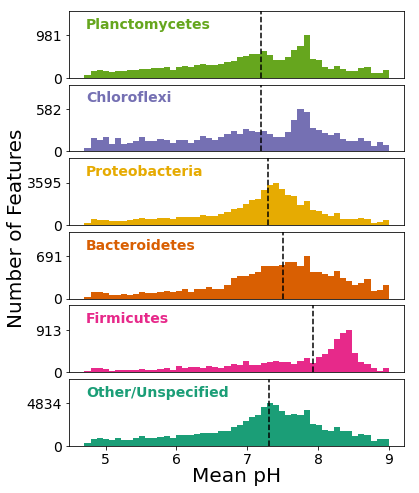

In [28]:
fig, axs = plt.subplots(6, 1, figsize=(6, 8), sharex=True)
plt.subplots_adjust(hspace=0.1)
order_dict = dict(zip(order, np.arange(len(order))))

ph_phyla_mean_df["rank"] = ph_phyla_mean_df["taxonomy_1"].map(order_dict)
ph_phyla_mean_df = ph_phyla_mean_df.sort_values(by="rank", ascending=True)

palette = dict(zip(
    [       
        "Other/Unspecified",
        "p__Bacteroidetes",
        "p__Chloroflexi",
        "p__Firmicutes",
        "p__Planctomycetes",
        "p__Proteobacteria",
    ],
    sns.color_palette("Dark2", 6))
)

for i, ax in enumerate(axs.flatten()):
    p = order[i]
    vals = ph_phyla_mean_df[ph_phyla_mean_df["taxonomy_1"] == p]["arithmetic_mean"]
    _g = ax.hist(
        vals,
        bins=50,
        color=palette[p],
    )
    ax.axvline(x = np.median(vals), color="black", linestyle="--")
    if i != 5: ax.xaxis.set_visible(False)
        
    _name = p
    if _name.startswith("p__"): _name = _name[3:]
    ax.text(
        x=0.05,
        y=0.9,
        s=f"{_name}",
        color=palette[p],
        ha="left",
        va="top",
        fontweight="bold",
        transform=ax.transAxes,
        fontsize=14,
    )
    
    _y1, _y2 = ax.get_ylim()    
    ax.set_ylim([_y1, _y2*1.5])
    
    ax.set_yticks([0, _g[0].max()])
    ax.set_yticklabels(map(int, [0, _g[0].max()]), fontsize=14)
    ax.tick_params("x", labelsize=14)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Number of Features", fontsize=20, labelpad=20)
plt.xlabel("Mean pH", fontsize=20)

plt.savefig("fig1/output/mean_ph_hist.svg", dpi=300, bbox_inches="tight")

plt.show()